# Project 2: Digit Classification Naive Bayes

**Solution**

# Intro
---
In this project, you'll continue working on your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. 
As always, you're welcome to work on the project in groups and discuss ideas over Slack, but <b> please prepare your own write-up (with your own code). </b>


## Grading
---
 - Make sure to answer every part in every question.
 - There are 6 questions, each equally weighted and an additional bonus question.
 - The extra credit question will be graded based on your attempts at feature engineering and resulting improved accuracy.
 - Read carefully what is asked including the notes.
 - Additional points may be deducted if:
   - the code is not clean, well commented,
  -  if the functions or answers are too long.

## Requirements:
---
1. Comment your code.
1. All graphs should have titles, label for each axis, and if needed a legend. It should be understandable on its own.
1. All code must run on colab.research.google.com
1. You should not import any additional libraries.
1. Try and minimize the use of the global namespace (meaning keep things in functions).

## Additional Reading and notes
---
If you're interested, check out these links related to digit recognition:

* Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/
* Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

Finally, if you'd like to get started with Tensorflow, you can read through this tutorial: https://www.tensorflow.org/tutorials/keras/basic_classification. It uses a dataset called "fashion_mnist", which is identical in structure to the original digit mnist, but uses images of clothing rather than images of digits. The number of training examples and number of labels is the same. In fact, you can simply replace the code that loads "fashion_mnist" with "mnist" and everything should work fine.

In [85]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

In [86]:
import sklearn
sklearn.__version__

'0.24.2'

Load the data. Notice that the data gets partitioned into training, development, and test sets. Also, a small subset of the training data called mini_train_data and mini_train_labels gets defined, which you should use in all the experiments below, unless otherwise noted.

In [87]:
# Load the digit data from https://www.openml.org/d/554 or from default local location '~/scikit_learn_data/...'
X, Y = fetch_openml(name='mnist_784', return_X_y=True, as_frame=False, cache=False)

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


### Question 1: Applying a smoothing using numpy.
---

A common image processing technique is to smooth an image by **blurring**. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian, i.e., the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

1. Implement a simplified Gaussian blur filter by just using the 8 neighboring pixels like this: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values.
1. Choose some weights as a starting point. Produce and evaluate four 1-Nearest Neighbor models by applying your blur filter in these ways:
  1. Do not use the filter
  1. Filter the training data but not the dev data
  1. Filter the dev data but not the training data
  1. Filter both training data and dev data
1. Show the accuracies of the four models evaluated as described. What do you see? Can you explain why this is?
1. Experiment with weights that makes one model's accuracy at least 0.9.

Notes:
* Train on the (filtered) mini train set.
* Evaluate performance on the (filtered) dev set.
* A good trick to simplify your code is to use numpy's pad function to add 0s around your original array so you don't have to deal with "edge cases".
* In addition, you can use numpy to multiply and sum slices of two arrays.
* [This notebook](https://colab.research.google.com/drive/1eJXTQLtREXQjQIsLOA9uCrBl6B049-pO) might help shows some example numpy code.
* In general, [numpy operations will be much faster than for loops](https://colab.research.google.com/drive/1KJI4JtuIqVdyZHTTe_mAlKYA5XdLFp3_). 
* There are other Guassian blur filters available, for example in `scipy.ndimage.filters`. You are welcome to experiment with those, but in this question, please implement your own.

In [90]:
def gaussian_filter(data, kernel):
    
    #array to hold filtered pixel values
    result = np.empty(data.shape)
    #for loop in order to go through all digits and reshape pixels + apply weightage
    for i in range(data.shape[0]):
        #shape filled in with 0s
        sample = data[i].reshape(28,28)
        image_row, image_col = sample.shape
        kernel_row, kernel_col = kernel.shape
        x = np.zeros(sample.shape)
        #add in weightage
        width = int((kernel_col-1)/2)
        height = int((kernel_row-1)/2)
        #new images
        a = 2*height
        b = 2*width
        weightedImage = np.zeros((image_row+a ,image_col+b))
        
        weightedImage[height:weightedImage.shape[0] - height, width:weightedImage.shape[1]- width] = sample
        
        #loop over each row in the image:
        for row in range(image_row):
            #loop over each column of the row being examined
            for column in range(image_col):
                x[row, column] = np.sum(kernel*weightedImage[row:row+kernel_row, column:column + kernel_col])
                
            x[row, column] /= kernel.shape[0] * kernel.shape[1]
            result[i] = x.reshape(1, 784)
    return result
        

In [98]:
def Q1():
    
### STUDENT START ###
    #initialize kernels
    kernel = np.ones((3,3),np.float32)/9
    
    #Model 1 - no blur
    k1 = KNeighborsClassifier(n_neighbors=1)
    k1.fit(mini_train_data, mini_train_labels)
    print("Model 1: No Blurring Accuracy:", k1.score(dev_data, dev_labels))
    
    #Model 2 - training data blur using helper function
    k2 = KNeighborsClassifier(n_neighbors=1)
    k2.fit(gaussian_filter(mini_train_data, kernel), mini_train_labels)
    print("Model 2: Training Data Blur, Dev Data No Blur Accuracy:", k2.score(dev_data, dev_labels))
    
    #Model 3 - dev data blur using helper function
    k3 = KNeighborsClassifier(n_neighbors=1)
    k3.fit(mini_train_data, mini_train_labels)
    print("Model 3: Training Data No Blur, Dev Data Blur Accuracy:", k3.score(gaussian_filter(dev_data, kernel), dev_labels))
    
    #Model 4 - training and dev data blur using function
    k4 = KNeighborsClassifier(n_neighbors=1)
    k4.fit(gaussian_filter(mini_train_data, kernel), mini_train_labels)
    print("Model 4: Training Data Blur, Dev Data Blur Accuracy:", k4.score(gaussian_filter(dev_data, kernel), dev_labels))
    
### STUDENT END ###

Q1()

Model 1: No Blurring Accuracy: 0.884
Model 2: Training Data Blur, Dev Data No Blur Accuracy: 0.907
Model 3: Training Data No Blur, Dev Data Blur Accuracy: 0.868
Model 4: Training Data Blur, Dev Data Blur Accuracy: 0.905


ANSWER: 

The model where only the training data was blurred seems to have the highest accuracy followed by a close second where the training data as well as the dev data are blurred. Seemingly, the training data being blurred is required to have a higher accuracy. Model 3 performed the worst which makes sense as the training data was not blurred where the model is trying to predict on blurred data. 

### Question 2: Modeling your data and experimenting with different Naive Bayes models. 
---

1. Produce two Naive Bayes models and evaluate their performances.  Recall that Naive Bayes estimates P(feature|label), where each label is a categorical, not a real number.
  1. For the first model, map pixel values to either 0 or 1, representing white or black - you should pre-process the data or use `BernoulliNB`'s `binarize` parameter to set the white/black separation threshold to 0.1.  Use `BernoulliNB` to produce the model.
  1. For the second model, map pixel values to either 0, 1, or 2, representing white, gray, or black - you should pre-process the data, seting the white/gray/black separation thresholds to 0.1 and 0.9.  Here you'll likely need to implement a `trianarize` helper function. Since we are going beyond the binary representation of our features, you should use `MultinomialNB` to produce the model.
1. Show the Bernoulli model accuracy and the Multinomial model accuracy.
1. Does the multinomial version improve the results? Why or why not?

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.



In [45]:
#trianarize helper function
def trianarize (images, lowThreshold, highThreshold):
    '''This is the trianarize helper function. The image represents the data to be trianarized, 
    while the return/output will be an array of trianarized images.
    '''
    #array where images will append after trianarization
    finalImages = []
    
    #for loop implemented for 3 different categories for trianarization
    for i in images:
        #White < 0.1
        i = np.where(i < lowThreshold, 0, i)
        
        #0.1 < Grey < 0.9
        i = np.where(((i >= lowThreshold) & (i <= highThreshold)), 1, i)
        finalImages.append(i)
        
        #Black > 0.9
        i = np.where(i > highThreshold, 2, i)

        
    return finalImages

In [46]:
# Solution with binarization by explicit binarize function

def Q2():

### STUDENT START ###
    ## Model 1 - binarization ##
    #use BernoulliNB's binarize parameter to set the white/black separation threshold to 0.1
    bernoulliModel = BernoulliNB(alpha=1, binarize=0.1)
    bernoulliModel.fit(mini_train_data, mini_train_labels)
    
    #find the accuracy of the bernoulli model
    bernoulliModelAccuracy = bernoulliModel.score(dev_data, dev_labels)
    print("The bernoulli model accuracy is", bernoulliModelAccuracy)
    
    ## Model 2 - Trianarization ##
    #set thresholdes as defined in the problem
    lowThreshold = 0.1
    highThreshold = 0.9
    
    #trianarize minitrain and dev data
    mini_train_dataTrianarized = trianarize(mini_train_data, lowThreshold, highThreshold)
    dev_dataTrianarized = trianarize(dev_data, lowThreshold, highThreshold)
    
    #use multinomialNB to produce the model
    multinomialModel = MultinomialNB(alpha = 1)
    multinomialModel.fit(mini_train_dataTrianarized, mini_train_labels)
    multinomialModelAccuracy = multinomialModel.score(dev_dataTrianarized, dev_labels)
    print("The multinomial model accurace is", multinomialModelAccuracy)
    
    
### STUDENT END ###

Q2()

The bernoulli model accuracy is 0.814
The multinomial model accurace is 0.807


ANSWER: 

The multinomial model does not improve the accuracy. As seen above, the value for the accuracy of the multinomial model is lower than the accuracy for the bernoulli model. Hence, it seems as though there is not much of a difference between binarization and trianarization. Both accuracies give similar amounts of information regarding pixels due to low pixel variability.

### Question 3: Applying the grid search technique.
1. Search across several values of the LaPlace smoothing parameter (alpha) to find its effect on a Bernoulli Naive Bayes model's performance.  Show the accuracy at each alpha value.
1. What is the best value for alpha? What is the accuracy when alpha is near 0? Is this what you'd expect?

Notes:
* Set binarization threshold to 0.
* Train on the mini train set.
* Evaluate performance by 5-fold cross-validation. 
* Use `GridSearchCV(..., ..., cv=..., scoring='accuracy', iid=False)` to vary alpha and evaluate performance by cross-validation.
* Cross-validation is based on partitions of the training data, so results will be a bit different than if you had used the dev set to evaluate performance.



In [58]:
def Q3(alphas):

### STUDENT START ###
    #set binarization threshold to 0
    BML = BernoulliNB(binarize = 0)
    
    #GridSearchCV(..., ..., cv=..., scoring='accuracy', iid=False) to vary alpha and evaluate performance by cross-validation
    grid = GridSearchCV(BML, param_grid = alphas, cv = 5, scoring='accuracy')
    
    #Train on minitrain set
    grid.fit(mini_train_data, mini_train_labels)
    
    #organize results in dataframe and print
    results = pd.DataFrame({" ": range(0,9),
                             "param_alpha":  grid.cv_results_['param_alpha'],  
                            "score": grid.cv_results_['mean_test_score']})
    print("#| Alpha |Score")
    print(results.to_string(index=False, header=False))
### STUDENT END ###

alphas = {'alpha': [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
Q3(alphas)


#| Alpha |Score
0     0.0 0.814
1  0.0001 0.819
2   0.001 0.825
3    0.01 0.822
4     0.1 0.818
5     0.5 0.813
6     1.0 0.809
7     2.0 0.805
8    10.0 0.783


ANSWER: 

The table above shows that the best score is with alpha .001. Theoretically, I expected that the trend to show that as alpha increases, there would be an increase in accuracy before a drop. This seems to be true with the values seen above where accuracy score increases until alpha .001 and then decrease thereafter. I expected for the increases to correlate with the weightage of increase with alphas but that doesn't seem to be the case - potentially due to the fact that the numerator of the calculation gets tipped over heavily once the alphas are past .001 thus resulting in a decrease in accuracy. 

### Question 4: Experimenting with Gaussian Naive Bayes
---
1. Produce a model using Guassian Naive Bayes, which is intended for real-valued features, and evaluate performance. You will notice that it does not work so well. 
1. Diagnose and explain the problem.
1. Apply a simple fix so that the model accuracy is around the same as for a Bernoulli Naive Bayes model. 
1. Show the model accuracy before your fix and the model accuracy after your fix.  
1. Explain your solution.

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.
* Take a look at var_smoothing argument for GaussianNB.
* Feel free to  examine theta and sigma to better understand what's happening. In general though, **it is not a good idea to mess with internal variables of the model**. These are stored in the model's `theta_` and `sigma_` attributes.

In [56]:
def Q4():

### STUDENT END ###
    ##Model 1: 
    #Produce a model using Guassian Naive Bayes and evaluate performance
    gaussianModel = GaussianNB()
    #fit on minitrain data and labels
    gaussianModel.fit(mini_train_data, mini_train_labels)
    #find the accuracy score
    gaussianAccuracy = gaussianModel.score(dev_data, dev_labels)
    #print results
    print("The Gaussian Naive Bayes Accuracy is", gaussianAccuracy)
    
    ##Model 2: 
    #Apply a simple fix so model accuracy is around the same as for a Bernoulli NB model
    gaussianV2 = GaussianNB(var_smoothing = 0.05)
    #fit on minitrain data and labels
    gaussianV2.fit(mini_train_data, mini_train_labels)
    #find the accuracy score
    gaussianV2Accuracy = gaussianV2.score(dev_data, dev_labels)
    #print results
    print("The Gaussian Naive Bayes Accuracy of the improved model is", gaussianV2Accuracy)
    
    #Variance Differences shown via DF
    smoothingValues = [1e-9, 0.0001, 0.001, 0.01, 0.05, 0.75, 0.1, 0.25, 0.5, 1.0, 1.5, 2.0, 2.5]
    accuracies = []
    for i in smoothingValues:
        gaussianV3 = GaussianNB(var_smoothing=i)
        gaussianV3.fit(mini_train_data, mini_train_labels)
        gaussianV3Accuracy = gaussianV3.score(dev_data, dev_labels)
        accuracies.append((i, gaussianV3Accuracy))
        
    smoothingDF = pd.DataFrame(accuracies, columns=['Smoothing Values', 'Accuracies'])
    print("================================")
    print(smoothingDF)
    
### STUDENT END ###

Q4()

The Gaussian Naive Bayes Accuracy is 0.593
The Gaussian Naive Bayes Accuracy of the improved model is 0.816
    Smoothing Values  Accuracies
0       1.000000e-09       0.593
1       1.000000e-04       0.721
2       1.000000e-03       0.758
3       1.000000e-02       0.797
4       5.000000e-02       0.816
5       7.500000e-01       0.748
6       1.000000e-01       0.817
7       2.500000e-01       0.797
8       5.000000e-01       0.764
9       1.000000e+00       0.737
10      1.500000e+00       0.722
11      2.000000e+00       0.706
12      2.500000e+00       0.699


ANSWER: 

The Gaussian Naive Bayes model performs badly relative to the improved model because the MNIST dataset procudes variance values close to 0; the 0 issue here is more evident here as opposed to in Q3. These values can have an adverse effect on the conditional probabilities calculated for the model. Some key considerations while working with Gaussian Naive Bayes as opposed to Bernoulli models are that the Gaussian NB models take in continuous input variables as opposed to binary input values in Bernoulli models. 

The solution is to increase the variance. We utilize var_smoothing to increase variance values so we no longer face the issue where they are close to 0. After var_smoothing is implemented, the conditionanl probabilities will be more reliable. The dataframe/table above demostrates the improved accuracies with respect to smoothing values. 

### Question 5: Naive Bayes as a generative model
---
Because Naive Bayes produces a generative model, you can use it to generate digit images.

1. Produce a Bernoulli Naive Bayes model and then use it to generate a 10x10 grid with 10 example images of each digit. Each pixel output will be either 0 or 1: randomly generating a number and then comparing it to the estimated probability of the pixel being either 0 or 1.  Show the grid.
1. How do the generated digit images compare to the training digit images?

Notes:
* You can use np.random.rand() to generate random numbers from a uniform distribution.
* The estimated probability of each pixel being 0 or 1 is stored in the model's `feature_log_prob_` attribute. You can use `np.exp()` to convert a log probability back to a probability.



The model accuracy is 0.829


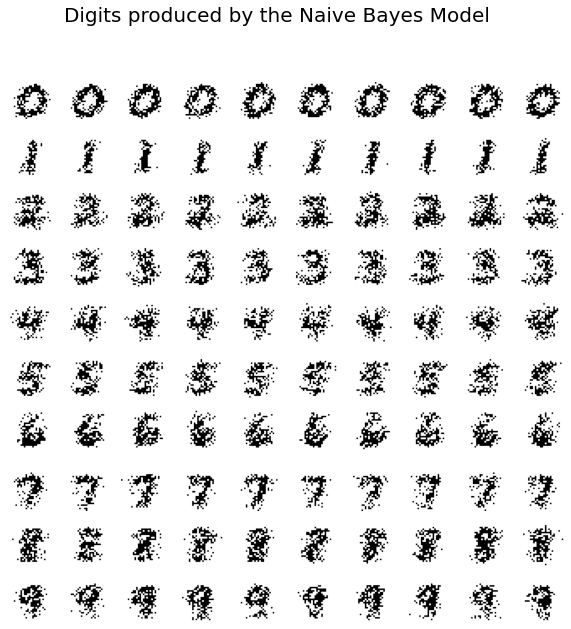

In [63]:
def Q5(num_examples):

### STUDENT START ###
    #setting alpha value to .001 as it resulted in the highest accuracy in Q3
    BNB = BernoulliNB(alpha = 0.001, binarize=0.1)
    #fit and train on minitrain data and labels
    BNB.fit(mini_train_data, mini_train_labels)
    #find accuracy of fit model
    BNBAccuracy = BNB.score(dev_data, dev_labels)
    print("The model accuracy is", BNBAccuracy)
    
    #estimated probability of the pixel being either 0 or 1
    estimatedProbability=np.exp(BNB.feature_log_prob_)
    randomize = np.random.rand(28,28)
    
    #Plot with the axes assigned, gray as colorscheme and a title
    fig, axes = plt.subplots(num_examples, num_examples, figsize=(10,10))
    plt.rc("image", cmap="Greys")
    plt.suptitle("Digits produced by the Naive Bayes Model", fontsize = 20)
    
    #for loop to go through each digit
    nums = np.unique(Y)
    for i, nums in enumerate(nums):
        new = estimatedProbability[i].reshape(28,28)
        for j in range(num_examples): 
            x = np.random.rand(28,28)
            axes[i,j].imshow(new > x)
            axes[i,j].axis("off")
            
### STUDENT END ###

Q5(10)

ANSWER: 

The digits generated above are evidentally worse than the digits within the training set. The digits above have less shape and definition which can be attributed to the randomness assigned to the probabilites of the pixels. In order to clean up any outlier pixels being accounted for, filters can be applied.

### Question 6: Model Calibraiton
---
Recall that:
 * a **strongly calibrated** classifier is rougly 90% accurate when it says it is 90% accurate. The model's estimated posterior probability of the predicted class is indeed 0.9. 
 * A **weakly calibrated** classifier is more accurate when it "says" it is more accurate. The actual accuracy is higher when the model's estimated posterior probability is higher.
 * A **poorly calibrated** classifier has no positive correlation between the model's estimate posterior probability and the actual accuracy.

1. Produce a Bernoulli Naive Bayes model.  
1. Evaluate performance: 
  1. Partition the dev set into several buckets based on the estimated posterior probabilities of the predicted classes (predict_proba)
    - Think of it as a bin in a histogram, where each bin groups a range of estimated posterior probabilities of the predicted classes (predict_proba).
    - Then estimate the actual accuracy the classifier achieved for each bucket. 
    - So, for each prediction:
       - Find the bucket whose range includes the estimated posterior probability, 
       - and update "correct" and "total" counters accordingly. 
       - Show the accuracy for each bucket.
1. How would you characterize the calibration for this Bernoulli Naive Bayes model according to the definitions above?

Notes:
* Set LaPlace smoothing (alpha) to the optimal value (from part 8).
* Set binarization threshold to 0.
* Train on the mini train set.
* Evaluate perfromance on the dev set.



In [70]:
def Q6(buckets, correct, total):
    
### STUDENT START ###
    ##Produce a Bernoulli Naive Bayes model.
    bnbModel = BernoulliNB(alpha=0.001, binarize=0)
    #fit the model on mini train data and labels
    bnbModel.fit(mini_train_data, mini_train_labels)
    #find the accuracy
    bnbModelAccuracy = bnbModel.score(dev_data, dev_labels)
    bnbModelPredict = bnbModel.predict(dev_data)
    
    print("The model accuracy is", bnbModelAccuracy)
    
    # posterior probability estimates of predicted classes
    posteriorProb = bnbModel.predict_proba(dev_data)
    
    for i in range(len(posteriorProb)):
        #keep track of the max probability
        maxProb = posteriorProb[i].max()
        for j in range(len(buckets)):
            #check to see if the prediction is in the range
            if maxProb <= buckets[j]:
                #check to see if the labels match then add 1 to correct bucket
                if bnbModelPredict[i] == dev_labels[i]:
                    correct[j] += 1
                #add 1 to the total column every time loop is used to account for total count
                total[j] += 1
                break
    
    accuracy = []
    for i in range(len(correct)):
        if total[i] != 0:
            accuracy.append(round(correct[i]/total[i], 3))
        else:
            accuracy.append(0.000)
            
    finalDF = pd.DataFrame({
        "Prediction Probability": buckets,
        "Correct": correct,
        "Total": total, 
        "Accuracy": accuracy
    })
    
    print(finalDF.to_string())
    print("======================================================================")
    print("The posterior probabilites are as seen below.")
    print(posteriorProb)
### STUDENT END ###

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

Q6(buckets, correct, total)

The model accuracy is 0.823
   Prediction Probability  Correct  Total  Accuracy
0                 0.50000        0      0     0.000
1                 0.90000       11     31     0.355
2                 0.99900       29     67     0.433
3                 0.99999       27     59     0.458
4                 1.00000       30     46     0.652
5                 1.00000       48     62     0.774
6                 1.00000       26     33     0.788
7                 1.00000       34     43     0.791
8                 1.00000      618    659     0.938
The posterior probabilites are as seen below.
[[1.95451339e-074 1.49842629e-069 4.62675151e-012 ... 1.81459178e-051
  8.34897989e-001 6.79698899e-041]
 [1.93410833e-086 0.00000000e+000 5.76592216e-034 ... 7.58486700e-091
  2.91977022e-048 3.37591067e-019]
 [2.48540245e-120 1.00000000e+000 2.98467831e-067 ... 3.06053798e-068
  2.30572970e-061 2.79609726e-083]
 ...
 [2.92767685e-078 8.58274110e-243 9.51689955e-053 ... 6.19128058e-042
  3.39095008e-05

ANSWER: 

This is a weakly calibrated model.

### Question 7 EXTRA CREDIT: Feature generation
---
1. Design new features to see if you can produce a Bernoulli Naive Bayes model with better performance.
1. Show the accuracy of a model based on the original features and the accuracy of the model based on the new features.

**Note that improving results is actually hard.**

Here are a few ideas to get you started:
- Try summing or averaging the pixel values in each row.
- Try summing or averaging the pixel values in each column.
- Try summing or averaging the pixel values in each square block. (pick various block sizes)
- Try implementing [*maxpool*](https://computersciencewiki.org/index.php/Max-pooling_/_Pooling) features, taking a rolling maximum over sub-regions of a the image. 
- In any case, you can either transform the original data or add new "features" to it.

Notes:
* Train on the mini train set (enhanced to comprise the new features).
* Evaulate performance on the dev set.
* Ensure that your code is well commented.

In [ ]:
def Q7():

### STUDENT START ###

### STUDENT END ###

Q7()